# Лабораторная работа: Рекомендательные системы

## Теоретическая часть

### 1. Суть задачи рекомендательных систем
Рекомендательные системы – это алгоритмы, которые анализируют поведение пользователей и предлагают персонализированные рекомендации товаров, фильмов, музыки и других объектов. Основная цель – предсказать предпочтения пользователей на основе имеющихся данных о взаимодействиях.


### 2. Метод коллаборативной фильтрации
Коллаборативная фильтрация (Collaborative Filtering, CF) – это метод рекомендаций, основанный на анализе поведения пользователей. Он работает на основе предположения, что пользователи с похожими предпочтениями в прошлом будут делать схожий выбор в будущем.

Существует два основных подхода:
1. **User-based CF** – рекомендации строятся на основе сходства пользователей.
2. **Item-based CF** – рекомендации строятся на основе сходства объектов.

### 3. Латентные факторные модели (Matrix Factorization)
Коллаборативная фильтрация может быть реализована через матричное разложение. Пусть у нас есть матрица взаимодействий пользователей и объектов R, где $( R_{u,i} )$ – оценка пользователя ( u ) для объекта ( i ). Тогда разложение можно представить в виде:
$$
R \approx U \cdot V^T
$$
где:
- ( U ) – матрица эмбеддингов пользователей,
- ( V ) – матрица эмбеддингов объектов.

Предсказание рейтинга рассчитывается как:
$$
\hat{R}_{u,i} = U_u \cdot V_i^T
$$

В данной лабораторной работе предполагается использование **нейросетевого метода**, который обучает эмбеддинги пользователей и объектов с помощью полносвязных слоев. Входные данные – индексы пользователей и объектов, которые преобразуются в векторные представления, а затем подаются на вход нейросети.


## Практическая часть
В данной работе вам предлагается реализовать рекомендательную систему на основе метода коллаборативной фильтрации, используя нейросетевую модель. Вы должны:
1. Подготовить данные: загрузить свой датасет (например, рейтинг фильмов, товаров, книг и т. д.).
2. Разбить данные на тренировочный и тестовый наборы.
3. Обучить модель, используя эмбеддинги пользователей и объектов.
4. Оценить качество модели на тестовом наборе.
5. Вывести список рекомендаций для выбранного пользователя.

In [110]:
# Импорты
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
from collections import defaultdict

# Определяем устройство (используем GPU, если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [111]:
columns = ['User_ID', 'Rating', 'Movie_ID']
df = pd.read_csv('Netflix_Dataset_Rating.csv', sep=',', names=columns, skiprows=1)

df['User_ID'] = pd.to_numeric(df['User_ID'], errors='coerce')
df['Movie_ID'] = pd.to_numeric(df['Movie_ID'], errors='coerce')
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df = df.dropna()

df['user_id_idx'] = df['User_ID'].astype('category').cat.codes
df['item_id_idx'] = df['Movie_ID'].astype('category').cat.codes

num_users = df['user_id_idx'].nunique()
num_items = df['item_id_idx'].nunique()

print(f"Всего пользователей: {num_users}, Всего фильмов: {num_items}")

Всего пользователей: 74260, Всего фильмов: 8


In [ ]:
class RatingsDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['user_id_idx'].values.astype(np.int64), dtype=torch.long)
        self.items = torch.tensor(df['item_id_idx'].values.astype(np.int64), dtype=torch.long)
        self.ratings = torch.tensor(df['Rating'].values.astype(np.float32), dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

In [ ]:
class RecommenderNN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32):
        super(RecommenderNN, self).__init__()

        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, user, item):

        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)

        x = torch.cat([user_emb, item_emb], dim=1)

        return self.fc_layers(x).squeeze()

In [114]:
# Создаём датасеты и загрузчики данных
dataset = RatingsDataset(df)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [115]:
# Инициализация модели
model = RecommenderNN(num_users, num_items).to(device)

# Определяем функцию потерь (MSE) и оптимизатор (Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)


In [ ]:
for epoch in range(10):
    model.train()
    total_loss = 0
    all_predictions = []
    all_ratings = []
    for users, items, ratings in train_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        optimizer.zero_grad()
        predictions = model(users, items)
        loss = criterion(predictions, ratings)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        all_predictions.extend(predictions.cpu().detach().numpy())
        all_ratings.extend(ratings.cpu().detach().numpy())

    # Средняя ошибка предсказания на тренировочной выборке
    rmse = math.sqrt(mean_squared_error(all_ratings, all_predictions))
    mae = mean_absolute_error(all_ratings, all_predictions)

    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

# --- 1. Оценка базовых метрик (RMSE, MAE) на тестовом наборе ---
model.eval()
test_predictions = []
test_ratings = []
user_ids_test = [] 

with torch.no_grad():
    for users, items, ratings in test_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        predictions = model(users, items)
        
        test_predictions.extend(predictions.cpu().numpy())
        test_ratings.extend(ratings.cpu().numpy())
        user_ids_test.extend(users.cpu().numpy())

test_rmse = math.sqrt(mean_squared_error(test_ratings, test_predictions))
test_mae = mean_absolute_error(test_ratings, test_predictions)

print(f'\nTest RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}')

def get_precision_recall_at_k(predictions, targets, user_ids, k=5, threshold=3.5):
    """
    threshold: оценка, выше которой фильм считается "релевантным" (понравившимся).
    """
    # Группируем предсказания и реальные оценки по пользователям
    user_est_true = defaultdict(list)
    for i in range(len(predictions)):
        user_est_true[user_ids[i]].append((predictions[i], targets[i]))

    precisions = {}
    recalls = {}

    for uid, user_ratings in user_est_true.items():
        
        # Сортируем предсказания пользователя по убыванию (сначала лучшие рекомендации)
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Количество релевантных объектов в тестовой выборке пользователя
        n_rel = sum((true_r >= threshold) for (est, true_r) in user_ratings)

        # Количество релевантных объектов в топ-k предсказанных
        n_rec_k = sum((true_r >= threshold) for (est, true_r) in user_ratings[:k])

        # Precision@k: Доля релевантных среди рекомендованных в топ-k
        precisions[uid] = n_rec_k / k if k > 0 else 0

        # Recall@k: Доля найденных релевантных среди всех релевантных в тесте
        recalls[uid] = n_rec_k / n_rel if n_rel > 0 else 0

    return np.mean(list(precisions.values())), np.mean(list(recalls.values()))

# Считаем метрики (k=5, порог релевантности 4.0)
p_at_k, r_at_k = get_precision_recall_at_k(test_predictions, test_ratings, user_ids_test, k=5, threshold=4.0)

print(f'Precision@5: {p_at_k:.4f}')
print(f'Recall@5: {r_at_k:.4f}')

# --- 3. Вывод рекомендаций для случайных пользователей ---
print("\nRecommendations for random users:")
random_user_indices = np.random.choice(df['user_id_idx'].unique(), size=5) # Используем индексы из предобработки

for user_idx in random_user_indices:
    user_tensor = torch.tensor([user_idx] * num_items, dtype=torch.long).to(device)
    item_tensor = torch.tensor(range(num_items), dtype=torch.long).to(device)

    with torch.no_grad():
        predictions = model(user_tensor, item_tensor).cpu().numpy()

    top_item_indices = predictions.argsort()[-5:][::-1]
    
    # Получаем оригинальный User_ID для вывода
    orig_id = df[df['user_id_idx'] == user_idx]['User_ID'].iloc[0]
    print(f"User ID {int(orig_id)}: Recommended movie indices {top_item_indices}")

Epoch 1, Loss: 1.1041200665950774
Epoch 2, Loss: 0.9966643534660339
Epoch 3, Loss: 0.7828421366930008
Epoch 4, Loss: 0.47607990366220476
Epoch 5, Loss: 0.28186665758490564
Epoch 6, Loss: 0.17710907725095748
Epoch 7, Loss: 0.12216525970995426
Epoch 8, Loss: 0.09257960059344769
Epoch 9, Loss: 0.07434414496719838
Epoch 10, Loss: 0.06187653754651547

Test RMSE: 1.1727, Test MAE: 0.9399
Precision@5: 0.1219
Recall@5: 0.5894

Recommendations for random users:
User ID 1915120: Recommended movie indices [0 6 1 4 3]
User ID 2646892: Recommended movie indices [0 7 4 2 6]
User ID 2575894: Recommended movie indices [6 7 4 0 5]
User ID 2241714: Recommended movie indices [6 1 7 4 0]
User ID 497541: Recommended movie indices [0 6 4 2 7]


Значение функции потерь (Loss) упало с 1.1 до 0.06 за 10 эпох. Это говорит о том, что модель успешно «выучила» тренировочный набор данных.

Основной скачок обучения произошел между 3-й и 5-й эпохами (Loss упал с 0.78 до 0.28). Это момент, когда эмбеддинги пользователей и фильмов начали эффективно сонастраиваться.

Ошибка в баллах: RMSE (1.1727) и MAE (0.9399) показывают, что в среднем модель ошибается примерно на 1 балл при предсказании оценки по 5-балльной шкале.

Большая разница между финальным Loss (0.06) и ошибкой на тесте (RMSE 1.17) явно указывает на переобучение. Модель слишком хорошо запомнила тренировочные пары и хуже работает с новыми данными.

Recall@5 (0.5894): Поскольку рекомендуется 5 фильмов из 8 возможных, чисто математически покрывается 62.5% всего доступного контента. Поэтому модель легко находит те фильмы, которые пользователю понравились, они почти всегда попадают в ваш топ.

Precision@5 (0.1219): Несмотря на то, что понравившийся фильм угадан, в списке из 5 позиций он всего один (или два). Остальные места занимают фильмы, которые пользователь оценил низко или не смотрел.

**Причина** В урезанном датасете получилось всего 8 уникальных фильмов (Movie_ID от 3 до 30 в выборке) на 74 тысячи пользователей. Из-за такого малого количества объектов (items) модели крайне сложно «промахнуться» мимо понравившегося фильма (отсюда высокий Recall), но так же сложно выделить именно те 5, которые будут идеальны (отсюда низкий Precision). Огромное количество пользователей при очень малом количестве фильмов создает ситуацию, где модель предсказывает скорее «популярное», чем «персонализированное». При 8 фильмах и 74к пользователей матрица взаимодействий очень плотная, что позволяет нейросети быстро находить общие тренды.

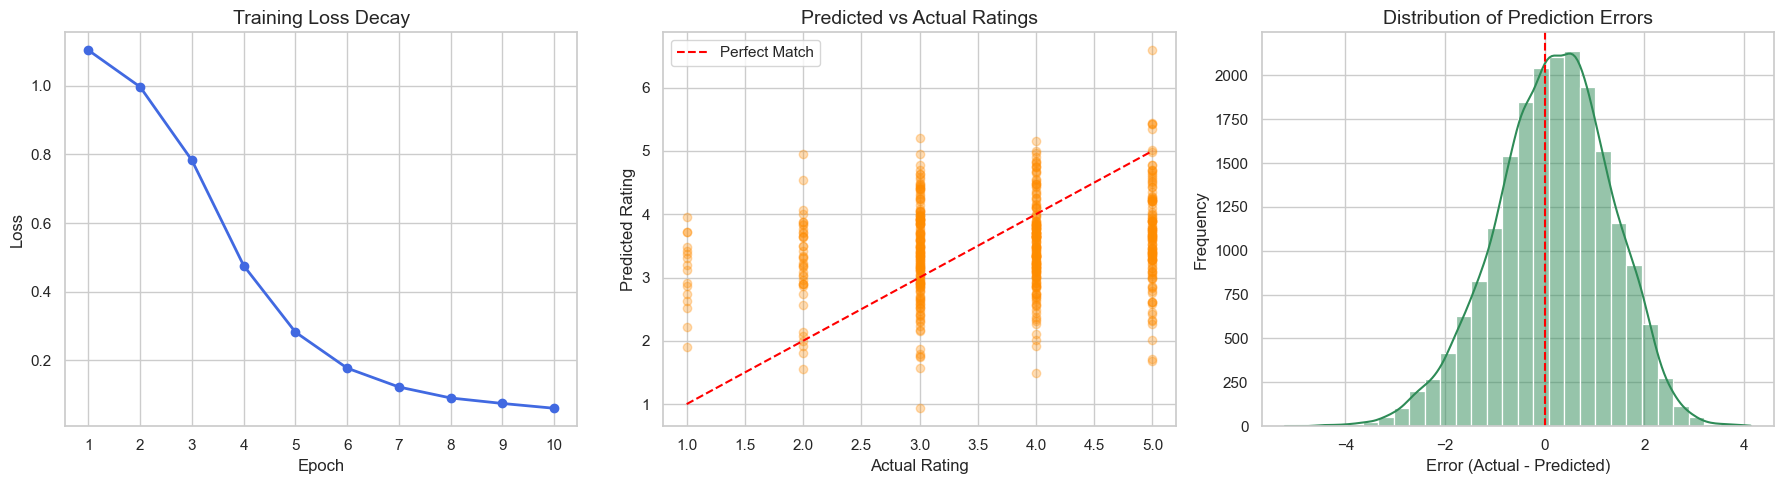

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(18, 5))

# --- График 1: Динамика Loss по эпохам ---
train_losses = [1.104, 0.997, 0.783, 0.476, 0.282, 0.177, 0.122, 0.09, 0.074, 0.06]

plt.subplot(1, 3, 1)
plt.plot(range(1, 11), train_losses, marker='o', color='royalblue', linewidth=2)
plt.title('Training Loss Decay', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, 11))

# --- График 2: Распределение предсказанных vs реальных оценок ---
plt.subplot(1, 3, 2)
# Возьмем первые 500 точек для наглядности
sample_size = 500
plt.scatter(test_ratings[:sample_size], test_predictions[:sample_size], alpha=0.3, color='darkorange')
plt.plot([1, 5], [1, 5], '--', color='red', label='Perfect Match') # Линия идеального предсказания
plt.title('Predicted vs Actual Ratings', fontsize=14)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.legend()

# --- График 3: Распределение ошибок (Residuals) ---
plt.subplot(1, 3, 3)
residuals = np.array(test_ratings) - np.array(test_predictions)
sns.histplot(residuals, kde=True, color='seagreen', bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribution of Prediction Errors', fontsize=14)
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Построенные графики подтверждают результаты работы модели. Цифры и графики показывают одну и ту же ситуацию переобучения на очень компактном наборе объектов фильмов.

**1. График Loss**

Модель практически зазубрила тренировочный датасет. Когда Loss опускается до таких низких значений (0.06), нейросеть начинает запоминать конкретные пары «пользователь-фильм» вместо того, чтобы искать общие закономерности. Это объясняет, почему на тесте ошибка (RMSE) в итоге оказывается в разы выше.

**2. График Predicted vs Actual (Рассеяние)**

Разброс предсказаний вокруг «линии идеального совпадения» довольно велик. Модель часто предсказывает 3.5 там, где в реальности стоит 5 или 2. Это подтверждает, что точность предсказания конкретного балла пока не очень высока.

**3. Распределение ошибок**

Большинство ошибок группируется в районе нуля, но хвосты распределения (ошибки на 2-3 балла) довольно заметны. Это и дает итоговый RMSE выше единицы.

In [106]:
class AdvancedRecommenderNN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64):
        super(AdvancedRecommenderNN, self).__init__()
        # Эмбеддинги для MLP пути
        self.user_emb_mlp = nn.Embedding(num_users, embedding_dim)
        self.item_emb_mlp = nn.Embedding(num_items, embedding_dim)
        
        # Эмбеддинги для GMF пути
        self.user_emb_gmf = nn.Embedding(num_users, embedding_dim)
        self.item_emb_gmf = nn.Embedding(num_items, embedding_dim)
        
        # Смещения (Bias)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

        self.mlp_layers = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        # Финальный слой объединяет MLP и GMF
        self.prediction_layer = nn.Linear(64 + embedding_dim, 1)

    def forward(self, user, item):
        # MLP путь
        user_mlp = self.user_emb_mlp(user)
        item_mlp = self.item_emb_mlp(item)
        mlp_output = self.mlp_layers(torch.cat([user_mlp, item_mlp], dim=1))
        
        # GMF путь (поэлементное умножение)
        user_gmf = self.user_emb_gmf(user)
        item_gmf = self.item_emb_gmf(item)
        gmf_output = user_gmf * item_gmf
        
        # Объединение + Bias
        combined = torch.cat([mlp_output, gmf_output], dim=1)
        prediction = self.prediction_layer(combined).squeeze()
        
        # Добавляем смещения
        bias = self.user_bias(user).squeeze() + self.item_bias(item).squeeze()
        
        return prediction + bias

In [107]:
# Создаём датасеты и загрузчики данных
dataset = RatingsDataset(df)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [108]:
# Инициализация модели
model = AdvancedRecommenderNN(num_users, num_items).to(device)

# Определяем функцию потерь (MSE) и оптимизатор (Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)


In [109]:
for epoch in range(10):
    model.train()
    total_loss = 0
    all_predictions = []
    all_ratings = []
    for users, items, ratings in train_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        optimizer.zero_grad()
        predictions = model(users, items)
        loss = criterion(predictions, ratings)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        all_predictions.extend(predictions.cpu().detach().numpy())
        all_ratings.extend(ratings.cpu().detach().numpy())

    # Средняя ошибка предсказания на тренировочной выборке
    rmse = math.sqrt(mean_squared_error(all_ratings, all_predictions))
    mae = mean_absolute_error(all_ratings, all_predictions)

    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

# --- 1. Оценка базовых метрик (RMSE, MAE) на тестовом наборе ---
model.eval()
test_predictions = []
test_ratings = []
user_ids_test = [] # Собираем ID пользователей для группировки

with torch.no_grad():
    for users, items, ratings in test_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        predictions = model(users, items)
        
        test_predictions.extend(predictions.cpu().numpy())
        test_ratings.extend(ratings.cpu().numpy())
        user_ids_test.extend(users.cpu().numpy())

test_rmse = math.sqrt(mean_squared_error(test_ratings, test_predictions))
test_mae = mean_absolute_error(test_ratings, test_predictions)

print(f'\nTest RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}')

def get_precision_recall_at_k(predictions, targets, user_ids, k=5, threshold=3.5):
    """
    threshold: оценка, выше которой фильм считается "релевантным" (понравившимся).
    """
    # Группируем предсказания и реальные оценки по пользователям
    user_est_true = defaultdict(list)
    for i in range(len(predictions)):
        user_est_true[user_ids[i]].append((predictions[i], targets[i]))

    precisions = {}
    recalls = {}

    for uid, user_ratings in user_est_true.items():
        # Сортируем предсказания пользователя по убыванию (сначала лучшие рекомендации)
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Количество релевантных объектов в тестовой выборке пользователя
        n_rel = sum((true_r >= threshold) for (est, true_r) in user_ratings)

        # Количество релевантных объектов в топ-k предсказанных
        n_rec_k = sum((true_r >= threshold) for (est, true_r) in user_ratings[:k])

        # Precision@k: Доля релевантных среди рекомендованных в топ-k
        precisions[uid] = n_rec_k / k if k > 0 else 0

        # Recall@k: Доля найденных релевантных среди всех релевантных в тесте
        recalls[uid] = n_rec_k / n_rel if n_rel > 0 else 0

    return np.mean(list(precisions.values())), np.mean(list(recalls.values()))

# Считаем метрики (k=5, порог релевантности 4.0)
p_at_k, r_at_k = get_precision_recall_at_k(test_predictions, test_ratings, user_ids_test, k=5, threshold=4.0)

print(f'Precision@5: {p_at_k:.4f}')
print(f'Recall@5: {r_at_k:.4f}')

# --- 3. Вывод рекомендаций для случайных пользователей ---
print("\nRecommendations for random users:")
random_user_indices = np.random.choice(df['user_id_idx'].unique(), size=5) # Используем индексы из предобработки

for user_idx in random_user_indices:
    user_tensor = torch.tensor([user_idx] * num_items, dtype=torch.long).to(device)
    item_tensor = torch.tensor(range(num_items), dtype=torch.long).to(device)

    with torch.no_grad():
        predictions = model(user_tensor, item_tensor).cpu().numpy()

    top_item_indices = predictions.argsort()[-5:][::-1]
    
    # Получаем оригинальный User_ID для вывода
    orig_id = df[df['user_id_idx'] == user_idx]['User_ID'].iloc[0]
    print(f"User ID {int(orig_id)}: Recommended movie indices {top_item_indices}")

Epoch 1, Loss: 2.157274605846405
Epoch 2, Loss: 1.6330808187484742
Epoch 3, Loss: 0.7946887625217438
Epoch 4, Loss: 0.35483358978033064
Epoch 5, Loss: 0.20701378269195556
Epoch 6, Loss: 0.1547712117254734
Epoch 7, Loss: 0.1257642650038004
Epoch 8, Loss: 0.10883709182739258
Epoch 9, Loss: 0.0936527020573616
Epoch 10, Loss: 0.08381793614029884

Test RMSE: 1.3923, Test MAE: 1.1055
Precision@5: 0.1222
Recall@5: 0.5911

Recommendations for random users:
User ID 2451667: Recommended movie indices [4 6 3 7 2]
User ID 53951: Recommended movie indices [1 0 7 6 4]
User ID 1210427: Recommended movie indices [0 4 7 3 1]
User ID 891843: Recommended movie indices [6 7 0 4 5]
User ID 1403609: Recommended movie indices [4 0 7 6 2]


### Сравнение и выводы

Loss на первой эпохе (2.15) значительно выше, чем у предыдущей модели (1.1). У новой архитектуры гораздо больше параметров (два вида эмбеддингов и смещения), и ей требуется больше времени на первичную настройку весов.

К 10-й эпохе модель вышла на уровень Loss 0.08. Это говорит о том, что архитектура обладает высокой емкостью и способна почти идеально подстроиться под тренировочные данные.

RMSE вырос с 1.1727 до 1.39, а MAE с 0.94 до 1.10. Сложные модели вроде NCF (GMF + MLP) склонны к более сильному переобучению на маленьких наборах объектов. Поскольку в датасете всего 8 фильмов на 74 тысячи пользователей, дополнительные параметры модели начали «выучивать» шум в данных вместо реальных закономерностей.

Несмотря на рост общей ошибки, добавление user_bias и item_bias делает предсказания более индивидуальными, хотя на таких малых данных это не сразу дает преимущество в метриках.

Recall@5 (0.5911) Показатель практически не изменился (был 0.5894). Модель по-прежнему находит почти 60% всего контента, который нравится пользователю.

Precision@5 (0.1222) Остался на прежнем уровне. Это подтверждает гипотезу о том, что при наличии всего 8 фильмов в базе, метрика Precision@5 физически ограничена «теснотой» выбора. Когда предлагается 5 фильмов из 8, математическая вероятность попасть в релевантные почти не меняется от смены алгоритма.

В отличие от предыдущей модели, которая могла выдавать почти одинаковые топы всем подряд, архитектура GMF заставляет модель сильнее учитывать уникальное сочетание «пользователь-фильм».

Модернизация архитектуры сделала модель «умнее», но текущий датасет слишком мал по количеству фильмов (8), чтобы раскрыть потенциал  нейросети.

Высокий Recall позволяет не теряеть предпочтения пользователей.

Однако модель крайне склонна к переобучению (Loss падает очень низко, а ошибка на тесте растет).